In [1]:
# Load modules
import pandas as pd
import geopandas as gpd
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.segmentation import flood
from skimage.feature import canny

In [2]:
# Define functions
def load_data(file_path):
    """
    Input: Raster file path 
    Output: Normalized array and geotransform information
    """
    try:
        gdal.UseExceptions()
        data = gdal.Open(file_path)
        if data is None:
            raise FileNotFoundError(f"Could not open file: {file_path}")
        data_array = data.ReadAsArray()
        geotransform = data.GetGeoTransform()
        return (data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array)), geotransform
    except Exception as e:
        raise RuntimeError(f"Error loading DEM: {e}")

def extract_indices(depression_df, geotransform):
    """
    Input: Depressions (dataframe) and geotransform information
    Output: Depressions (dataframe) with location in pixel indices
    """

    # Extract geotransform parameters
    x_origin = geotransform[0]
    y_origin = geotransform[3]
    pixel_width = geotransform[1]
    pixel_height = geotransform[5]

    # Convert to raster pixel indices
    depression_df["col"] = ((depression_df["longitude"] - x_origin) / pixel_width).astype(int)
    depression_df["row"] = ((depression_df["latitude"] - y_origin) / pixel_height).astype(int)

    return depression_df

def extract_windows(df, dem_array, slope_array, aspect_array, curvature_array, flood_tolerance=0.005, window_size=50):
    """
    Input: Depressions (dataframe) and dem, slope, aspect and curvature arrays, flood tolerance and window size
    Output: Features and labels arrays
    """
    half_window = window_size // 2  
    features_list, labels_list = [], []
    
    for _, row in df.iterrows():
        row_idx, col_idx = row["row"], row["col"]
        row_min, row_max = max(row_idx - half_window, 0), min(row_idx + half_window, dem_array.shape[0])
        col_min, col_max = max(col_idx - half_window, 0), min(col_idx + half_window, dem_array.shape[1])

        window_dem = dem_array[row_min:row_max, col_min:col_max]
        window_slope = slope_array[row_min:row_max, col_min:col_max]
        window_aspect_sin = np.sin(aspect_array[row_min:row_max, col_min:col_max])
        window_aspect_cos = np.cos(aspect_array[row_min:row_max, col_min:col_max])
        window_curvature = curvature_array[row_min:row_max, col_min:col_max]

        # flood segmentation mask
        seed_row, seed_col = row_idx - row_min, col_idx - col_min
        if (0 <= seed_row < window_dem.shape[0]) and (0 <= seed_col < window_dem.shape[1]):
            window_flood = flood(window_dem, (seed_row, seed_col), tolerance=flood_tolerance)
        else:
            window_flood = np.zeros_like(window_dem, np.float32)

        # edge detection using Canny
        window_edge = canny(window_slope)
        
        feature_stack = np.stack([
            window_dem,
            window_slope,
            window_aspect_sin,
            window_aspect_cos,
            window_curvature,
            window_flood,
            window_edge
        ], axis=-1)
        
        features_list.append(feature_stack)
        labels_list.append(row["type"])
    
    return np.array(features_list, dtype=np.float32), np.array(labels_list, dtype=np.str_)


In [6]:
# Load DEM, slope, aspect and concavity
dem_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\Data\tifs\test_area_DHMVIIDTMRAS1m_k32.tif"
slope_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\Data\tifs\test_area_slope1m_k32.tif"
aspect_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\Data\tifs\test_area_aspect1m_k32.tif"
curvature_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\Data\tifs\test_area_profile_curvature1m_k32.tif"

dem_array, dem_transform = load_data(dem_path)
slope_array, _ = load_data(slope_path)
aspect_array, _ = load_data(aspect_path)
curvature_array, _ = load_data(curvature_path)

In [7]:
# Load depressions
non_CD_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\Data\test_area_non-CDs_minima.shp"
non_CD_df = gpd.read_file(non_CD_path)
CD_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\Data\test_area_CDs_minima.shp"
CD_df = gpd.read_file(CD_path)

In [8]:
# Set output path
features0_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\test_area_non_CD_features.npy"
labels0_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\test_area_non_CD_labels.npy"
features1_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\test_area_CD_features.npy"
labels1_path = r"C:\Users\sarah\OneDrive\Documenten\GitHub\thesis-cd-github\test_area_CD_labels.npy"

In [9]:
# Extract depression indices
non_CD_df = extract_indices(non_CD_df, dem_transform)
CD_df = extract_indices(CD_df, dem_transform)

In [10]:
# Extract windows
features0_array, labels0_array = extract_windows(non_CD_df, dem_array, slope_array, aspect_array, curvature_array)
features1_array, labels1_array = extract_windows(CD_df, dem_array, slope_array, aspect_array, curvature_array)

labels0_encoded = np.zeros((len(labels0_array), features0_array.shape[1]), dtype=np.int32)
labels1_encoded = np.ones((len(labels0_array), features1_array.shape[1]), dtype=np.int32)

# Save the arrays
np.save(features0_path, features0_array)
np.save(labels0_path, labels0_encoded)
np.save(features1_path, features1_array)
np.save(labels1_path, labels1_encoded)

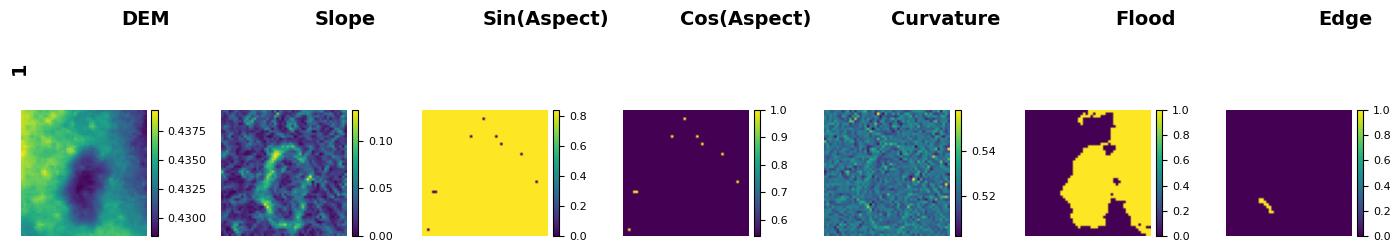

In [14]:
# Quick visualization
unique_labels = np.unique(labels1_encoded)
label_examples = {label: np.where(labels1_encoded == label)[0][0] for label in unique_labels}

n_rows, n_cols = len(unique_labels), 7
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows), squeeze=False)
feature_names = ["DEM", "Slope", "Sin(Aspect)", "Cos(Aspect)", "Curvature", "Flood", "Edge"]

for col, name in enumerate(feature_names):
    fig.text(0.10 + (col / n_cols), 0.98, name, fontsize=14, fontweight="bold", ha="center", va="bottom")

for row, (label, idx) in enumerate(label_examples.items()):
    for col in range(n_cols):
        ax = axes[row, col]
        im = ax.imshow(features1_array[idx, :, :, col], cmap="viridis")
        ax.axis("off")
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    
    fig.text(0.01, 0.85 - (row / n_rows), label, fontsize=14, fontweight="bold", ha="center", va="center", 
            rotation=90, transform=fig.transFigure)

plt.tight_layout()
plt.show()
